<a href="https://colab.research.google.com/github/Kryptera-K/BG-CCI-Zero-Line-Mean-Reversion-with-Price-Action-Strategy/blob/main/BG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BG"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BG_clean.csv", index=False)
df

/tmp/ipython-input-8941028.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2001-08-02,9.814846,9.863920,9.299567,9.814846,9812900
2001-08-03,9.814846,9.863920,9.814846,9.814846,2776400
2001-08-06,9.814846,9.814846,9.692161,9.814846,416700
2001-08-07,9.814846,9.814846,9.741235,9.814846,1651800
2001-08-08,9.814846,9.814846,9.741235,9.790309,265800
...,...,...,...,...,...
2025-12-24,88.690002,89.160004,88.519997,89.110001,591000
2025-12-26,89.080002,89.169998,88.370003,88.669998,810000
2025-12-29,89.360001,89.489998,88.730003,88.959999,1352200


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

CCI_LEVEL = 0
CCI_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def cci_lower_than(df, period=CCI_PERIOD, level=CCI_LEVEL):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return df['CCI_main'] < level


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def hammer(df):
    body = abs(df['Close'] - df['Open'])
    lower_shadow = df[['Open','Close']].min(axis=1) - df['Low']
    upper_shadow = df['High'] - df[['Open','Close']].max(axis=1)
    return (lower_shadow >= 2 * body) & (upper_shadow <= body)



# -------------------------
# Entry conditions
# -------------------------

df["CCI_Lower_Than_Level"] = cci_lower_than(df)

# -------------------------
# Exit conditions
# -------------------------

df["Hammer"] = hammer(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'CCI_Lower_Than_Level',
]
exit_conditions = [
    'Hammer',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2001-08-02 00:00:00
End                                  2025-12-31 00:00:00
Period                                6140 days 00:00:00
Start Value                                     100000.0
End Value                                 1147511.641892
Total Return [%]                             1047.511642
Benchmark Return [%]                          811.883891
Max Gross Exposure [%]                             100.0
Total Fees Paid                            157647.084032
Max Drawdown [%]                               75.119963
Max Drawdown Duration                 1602 days 00:00:00
Total Trades                                         113
Total Closed Trades                                  112
Total Open Trades                                      1
Open Trade PnL                             118564.875209
Win Rate [%]                                   66.071429
Best Trade [%]                                 50.820481
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2001-08-02 00:00:00
End                           2025-12-31 00:00:00
Period                         6140 days 00:00:00
Start Value                              100000.0
End Value                           911883.891464
Total Return [%]                       811.883891
Benchmark Return [%]                   811.883891
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        76.669311
Max Drawdown Duration          3524 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      811883.891464
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2235423744.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


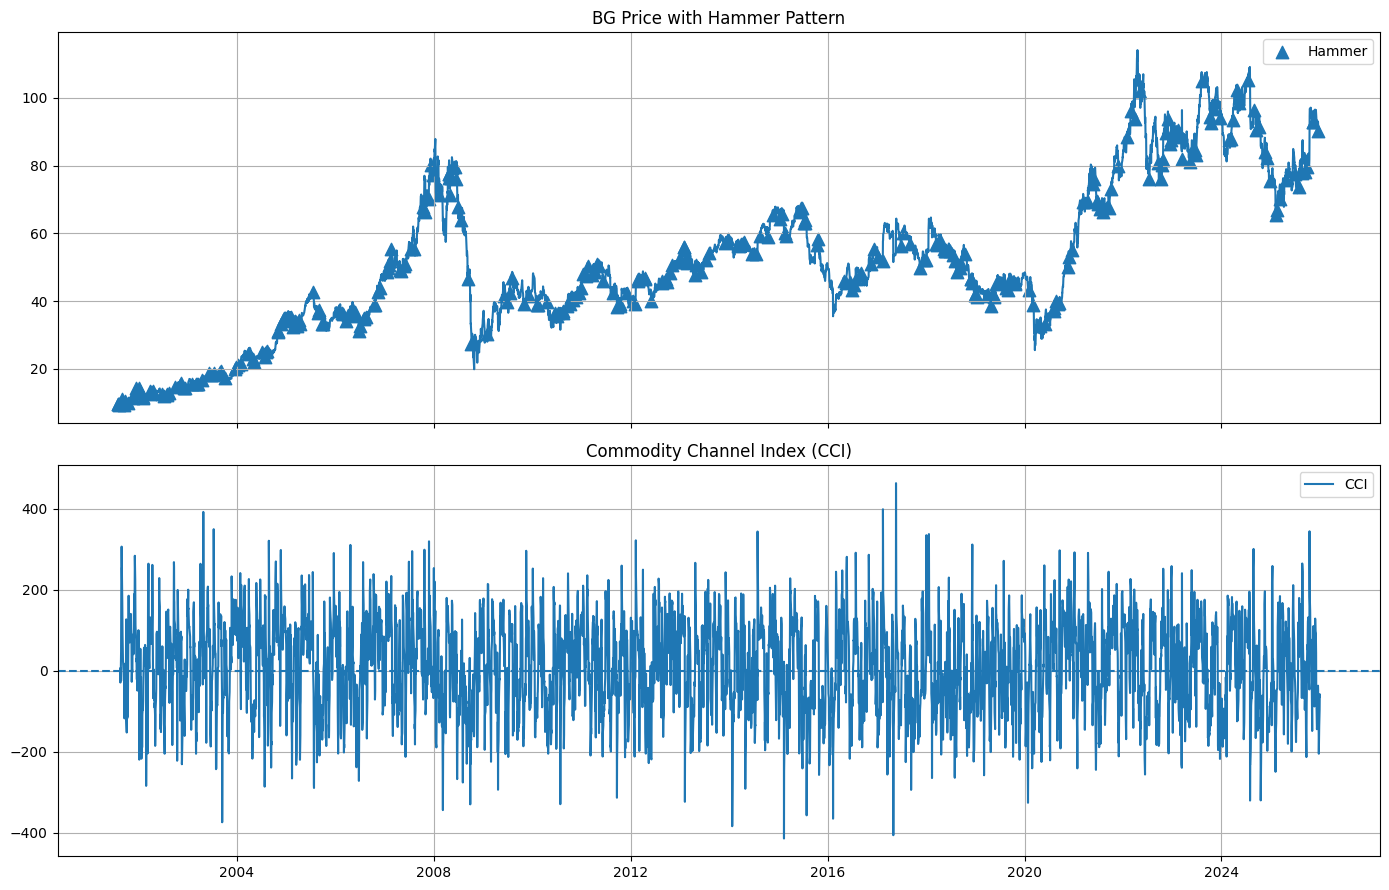

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "BG"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------
CCI_PERIOD = 14
CCI_LEVEL = 0

# -------------------------
# Indicator Functions
# -------------------------
def calculate_cci(df, period=14):
    df = df.copy()
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(period).mean()
    mean_dev = tp.rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    cci = (tp - sma_tp) / (0.015 * mean_dev)
    return cci

def hammer(df):
    body = abs(df['Close'] - df['Open'])
    lower_shadow = df[['Open', 'Close']].min(axis=1) - df['Low']
    upper_shadow = df['High'] - df[['Open', 'Close']].max(axis=1)
    return (lower_shadow >= 2 * body) & (upper_shadow <= body)

# -------------------------
# Calculate Indicators
# -------------------------
df['CCI'] = calculate_cci(df, CCI_PERIOD)
df['Hammer'] = hammer(df)

# -------------------------
# Plot
# -------------------------
fig, (ax_price, ax_cci) = plt.subplots(
    2, 1, figsize=(14, 9), sharex=True
)

# ---- Price Plot ----
ax_price.plot(df.index, df['Close'])
ax_price.scatter(
    df.index[df['Hammer']],
    df['Low'][df['Hammer']],
    marker='^',
    s=80,
    label='Hammer'
)
ax_price.set_title(f"{symbol} Price with Hammer Pattern")
ax_price.legend()
ax_price.grid(True)

# ---- CCI Plot ----
ax_cci.plot(df.index, df['CCI'], label='CCI')
ax_cci.axhline(CCI_LEVEL, linestyle='--')
ax_cci.set_title("Commodity Channel Index (CCI)")
ax_cci.legend()
ax_cci.grid(True)

plt.tight_layout()
plt.show()
